In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit import *
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity, Statevector, Operator, Pauli, SparsePauliOp
from qiskit import Aer
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal, PauliEvolutionGate
from qiskit.algorithms import TimeEvolutionProblem, RealTimeEvolver, RealEvolver, SciPyRealEvolver, VarQRTE
from qiskit.algorithms.time_evolvers import TrotterQRTE
from qiskit.circuit import Parameter, ParameterVector
from qiskit.synthesis import SuzukiTrotter, LieTrotter


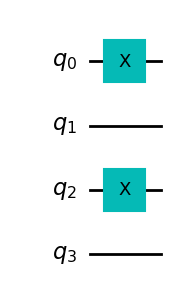

In [159]:
# Prepare a Dihydrogen Molecule within its second_q_op structure:

h2_driver = PySCFDriver(
    atom = "H 0 0 0; H 0 0 0.735",
    basis = "sto3g",
    charge = 0,
    spin = 0,
    unit = DistanceUnit.ANGSTROM,
)

# Create Problem instance for dihydrogen molecule:

diHydro_prob = h2_driver.run()

# Generate the Electronic Hamiltonian for Dihydrogen:

h2_Hamiltonian = diHydro_prob.hamiltonian
coefficients = h2_Hamiltonian.electronic_integrals

# Apply second-quantization transformation to Electronic Hamiltonian:

sq_h2_op = h2_Hamiltonian.second_q_op() # This Second-Quantized Electronic Hamiltonian does NOT contain the nuclei repulsive/attractive terms!

# Set up Jordan-Wigner Mapper/Transformer to bring Second Quantized Hamiltonian into qubit space:

jw_map = JordanWignerMapper()

# Apply mapper to Second Quantized Electronic Hamiltonian:

qubit_h2_Ham = jw_map.map(sq_h2_op)

# Obtain the initial state from which to apply the time evolution of the converted Hamiltonian:

HartreeFock_initial = HartreeFock(diHydro_prob.num_spatial_orbitals, diHydro_prob.num_particles, jw_map,)

# Draw the initial state to evolve:

HartreeFock_initial.draw('mpl')

#evo_time = Parameter('t')

In [84]:
'''initial_state = QuantumCircuit(4)

initial_state.x([0, 2])

initial_state.draw()'''

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────

In [129]:
# Dear god, please work:

operator = SparsePauliOp([Pauli("IXXZ"), Pauli("IIII"), Pauli("XXYY")])

t = Parameter('t')
Lying = list()
Suzy = list()

time_range = np.arange(0, 100, 1)

for k in range(len(time_range)):

    Suzy.append(SuzukiTrotter(2, 2, False, "chain", None).synthesize(PauliEvolutionGate(qubit_h2_Ham, time=time_range[k]/5)))
    Lying.append(HartreeFock_initial.compose(LieTrotter(2, True, "chain", None).synthesize(PauliEvolutionGate(qubit_h2_Ham, time=time_range[k]/5))))

#Suzuki.draw()

In [128]:
# Compose:

#circ = HartreeFock_initial.compose()

#circ.draw()


In [126]:
# Simulate:

estimator = Estimator()
energies = list()

for k in range(len(time_range)):
    result = estimator.run(Lying[k], qubit_h2_Ham).result()
    energies.append(np.real(result.values))

#print()s



Text(0, 0.5, 'Energy (Hartree)')

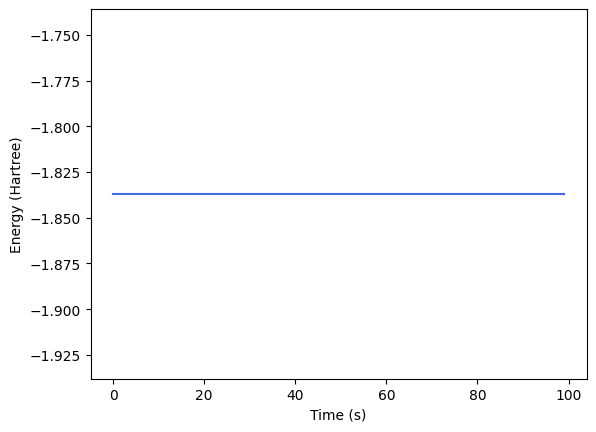

In [127]:
plt.plot(time_range, energies, color="royalblue")
plt.xlabel("Time (s)")
plt.ylabel("Energy (Hartree)")
#plt.title("Expectation Value of Dihydrogen w/ Order = " + str(PF_order) + " and Trotter Number = " + str(Trotter_Num))


In [100]:
estimator = Estimator()

scipy_prob = TimeEvolutionProblem(qubit_h2_Ham, 1000, HartreeFock_initial)

scipy = SciPyRealEvolver(1)

evo_circ = scipy.evolve(scipy_prob).evolved_state


print(evo_circ.expectation_value(qubit_h2_Ham))





(-1.8369679912787567+0j)


[array([-1.83696799]), array([-1.83674242]), array([-1.8360644]), array([-1.83493007]), array([-1.83333301]), array([-1.83126433]), array([-1.82871273]), array([-1.82566463]), array([-1.82210429]), array([-1.81801395]), array([-1.81337402]), array([-1.80816327]), array([-1.80235901]), array([-1.79593735]), array([-1.7888734]), array([-1.78114158]), array([-1.77271581]), array([-1.76356984]), array([-1.75367751]), array([-1.74301302]), array([-1.73155127]), array([-1.71926806]), array([-1.70614049]), array([-1.69214715]), array([-1.67726846]), array([-1.66148693]), array([-1.64478741]), array([-1.62715738]), array([-1.60858715]), array([-1.58907013]), array([-1.56860299]), array([-1.54718592]), array([-1.52482274]), array([-1.5015211]), array([-1.47729258]), array([-1.45215282]), array([-1.42612158]), array([-1.39922283]), array([-1.37148477]), array([-1.34293981]), array([-1.3136246]), array([-1.28357996]), array([-1.25285079]), array([-1.22148601]), array([-1.1895384]), array([-1.1570

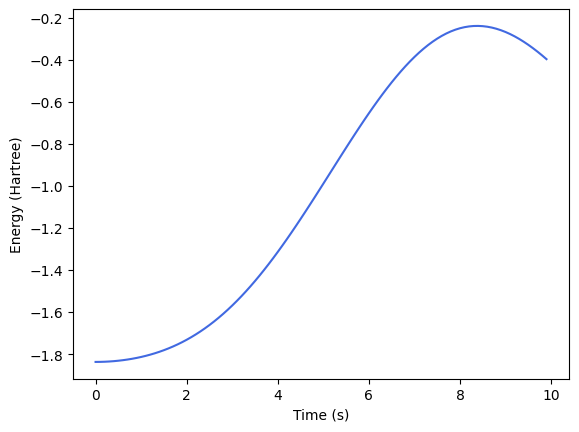

In [181]:
#from qiskit_ibm_runtime import QiskitRuntimeService, Estimator

#ervice = QiskitRuntimeService(channel="ibm_quantum")
#backend = service.backend("ibmq_qasm_simulator")

estimator = Estimator()

hem = list()

#param = Parameter('t')

#hey = HartreeFock_initial

#hey.hamiltonian(qubit_h2_Ham, param, qubits= [0, 1, 2, 3])

Suzuki = SuzukiTrotter(2, 4, False, "chain")
Lie = LieTrotter(4, False, "chain", None) 

time_range = np.arange(0, 10, 0.1)

for i in range(len(time_range)):

    hem.append(estimator.run(HartreeFock_initial.compose(PauliEvolutionGate(qubit_h2_Ham, time=time_range[i])), qubit_h2_Ham).result().values)


plt.plot(time_range, hem, color="royalblue")
plt.xlabel("Time (s)")
plt.ylabel("Energy (Hartree)")

print(hem)

In [182]:
print(hem[-1])

[-0.39625646]


In [186]:
import numpy as np

from qiskit.algorithms import TimeEvolutionProblem, VarQITE
from qiskit.algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp.from_list(
    [
        ("II", 0.2252),
        ("ZZ", 0.5716),
        ("IZ", 0.3435),
        ("ZI", -0.4347),
        ("YY", 0.091),
        ("XX", 0.091),
    ]
)

ansatz = EfficientSU2(observable.num_qubits, reps=1)
init_param_values = np.zeros(len(ansatz.parameters))
for i in range(len(ansatz.parameters)):
    init_param_values[i] = np.pi / 2
var_principle = ImaginaryMcLachlanPrinciple()
time = 1
evolution_problem = TimeEvolutionProblem(observable, time)
var_qite = VarQITE(ansatz, var_principle, init_param_values)
evolution_result = var_qite.evolve(evolution_problem)

TypeError: Unsupported type of param_values provided: <class 'qiskit.algorithms.time_evolvers.variational.variational_principles.imaginary_mc_lachlan_principle.ImaginaryMcLachlanPrinciple'>.

In [173]:
# Via TrotterQRTE:

evo_range = np.arange(0, 100, 1)

evo_list = list() 

for k in range(len(evo_range)):

    evo_prob = TimeEvolutionProblem(qubit_h2_Ham, evo_range[k], HartreeFock_initial)

    estimator = Estimator()

    trotter = SuzukiTrotter(2, True, "chain", None)

    trotter_qrte = TrotterQRTE(product_formula=trotter, estimator=estimator, num_timesteps=1)

    evolved_state = trotter_qrte.evolve(evo_prob).evolved_state

    result = estimator.run(evolved_state, qubit_h2_Ham, None).result()

    evo_list.append(np.real(result.values))

    

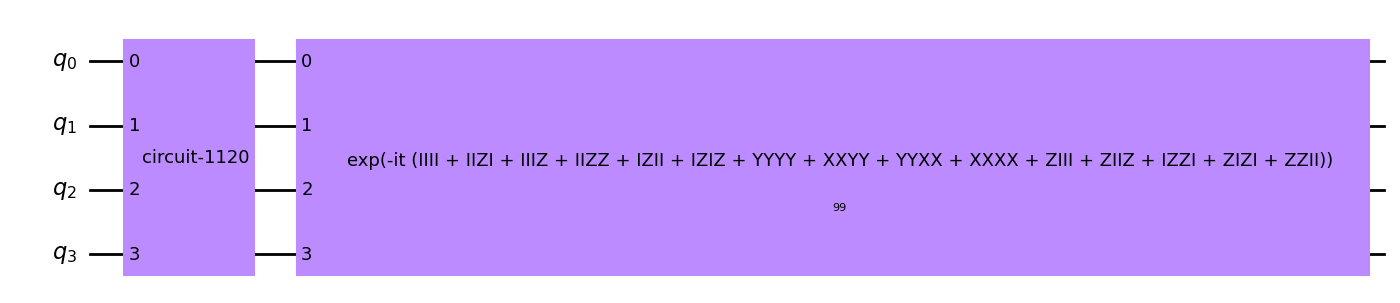

In [174]:
evolved_state.draw('mpl')

Text(0.5, 1.0, 'Expectation Value of Dihydrogen w/ Order = 1 and Trotter Number = 1')

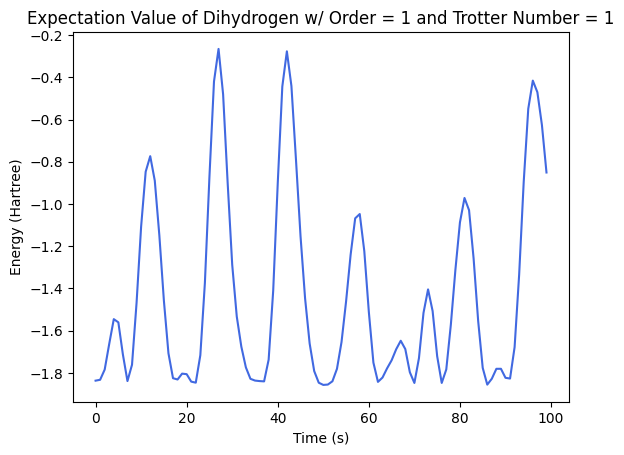

In [177]:
plt.plot(evo_range, evo_list, color="royalblue")
plt.xlabel("Time (s)")
plt.ylabel("Energy (Hartree)")
plt.title("Expectation Value of Dihydrogen w/ Order = " + str(1) + " and Trotter Number = " + str(1))

In [169]:
result = estimator.run(evolved_state, qubit_h2_Ham, None).result()

In [170]:
result.values

array([-1.43375892])